# Fit model parameters to single variable data (voltage)

This notebook demonstrates step by step how to fit a PyBaMM model to single variable data (in this case voltage), demonstrating the core capabilities of pybamm-param. The workflow to perform the data fitting is:
1. Load the data
2. Define the model (via a PyBaMM simulation)
3. Define the optimisation problem
4. Solve the optimisation problem
5. Process the result

We start by importing the relevant packages.

In [1]:
# %pip install git+https://github.com/paramm-team/pybamm-param.git -q # Can be used for Google Colab
import pybamm
import pbparam
import pandas as pd
import os

## 1. Load the data
The first step is to load the data to which we want to fit the model. For this example, we use the experimental dataset which from [Brosa Planella et al. (2021) article](https://www.sciencedirect.com/science/article/pii/S0013468621008148). This data set is already in the right format, if you are using your own dataset you should ensure that the headers of the relevant columns match the variable names in PyBaMM (e.g. `"Time [s]"`, `"Voltage [V]"`...)

In [2]:
os.chdir(os.path.join(pbparam.__path__[0], "input", "data")) # Path change to where the data is stored
data = pd.read_csv("LGM50_789_1C_25degC.csv")

## 2. Define the model
Next we need to define the model we want to fit to the data. This also includes defining the solver, spatial methods, parameters that we are not fitting, and operating conditions. To streamline this, we wrap everything into a PyBaMM simulation. The basic idea is that the simulation already includes everything needed to solve the model under certain conditions.

In this case we choose the Single Particle Model (SPM) with a contact resistance, which we will fit to the data.

In [3]:
model = pybamm.lithium_ion.SPM(
    options={
        "contact resistance": "true"
    },
)

In this case we will fit the negative electrode diffusion coefficient and the contact resistance, but we need to provide the remaining parameters. We choose the `"Chen2020"` dataset as it matches the data we are using. Note that this will also include values for the parameters we are fitting, but pybamm-param will override those automatically.

In [4]:
param = pybamm.ParameterValues("Chen2020")

We also need to define the operating conditions. In this case we want to do 1C discharge followed by a 2-hour rest, so we define a PyBaMM Experiment.

In [5]:
experiment = pybamm.Experiment(
    [
        "Discharge at 1C until 2.5 V",
        "Rest for 2 hours",
    ],
    period="30 seconds",
)

Finally, we combine everything into a PyBaMM simulation (see [PyBaMM documentation](https://docs.pybamm.org)) for more information.

In [6]:
simulation = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=experiment,
)

## 3. Define the optimisation problem
Now we need to define the optimisation problem (defined as an `OptimisationProblem` object), which tells pybamm-param which kind of data fit we want to perform. The package various optimisation problems tailored to specific experiments (OCP balance, GITT...). In this case, we have the most generic scenario which is to fit a user-defined model to some experimental data, so we will need to use the `DataFit` class.

The optimisation problems gather all the necessary components to perform the data fit (model, data, parameters to optimise, initial values...), similar to what the `Simulation` class does in PyBaMM. We have already loaded the data and defined the model, so we just need to specify which parameters we want to fit and provide an initial guess and bounds. They need to be passed as a dictionary of the following form: `{"parameter name": (initial guess, (lower bound, upper bound))}`.

In [7]:
param_optimise = {
    "Negative electrode diffusivity [m2.s-1]": (5e-14, (2.06e-16, 2.06e-12)),
    "Contact resistance [Ohm]": (0, (0, 0.5)),
}

By default `DataFit` assumes the variable in the data to fit to is voltage. In the [multivariable example](./datafit_multivariable.ipynb) we show how to specify other variables to fit to. Now that we have all the components, we can assemble the `DataFit` optimisation problem.

In [8]:
opt = pbparam.DataFit(simulation, data, param_optimise)

## 4. Solve the optimisation problem
Once the optimisation problem has been defined, we can solve it. To do so, we need to choose which optimiser we want to use (you can find the various optimisers available in [the documentation](https://pybamm-param.readthedocs.io/)). Optimisers are to optimisation problems, what solvers are to PyBaMM simulations.

In this case we want to use the Scipy's `minimize` solver with the Nelder-Mead method. Pybamm-param provides a wrapper around that solver that we can use.

In [9]:
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

Now we can tell the optimiser to solve the optimisation problem (i.e. optimise). This will output a `result` that we can store.

In [10]:
result = optimiser.optimise(opt)

## 5. Process the result
Finally we can process the result of the optimisation problem. The optimisation result contains all the information (including the optimal values), and we can quickly visualise the information by printing it.

In [11]:
print(result)


             Optimal values: {'Negative electrode diffusivity [m2.s-1]': 1.8491654663783702e-14, 'Contact resistance [Ohm]': 0.020944162147087393}
             Initial values: {'Negative electrode diffusivity [m2.s-1]': 1.0, 'Contact resistance [Ohm]': 0.0}
                  Optimiser: Root Mean Square Error
        Cost function value: 0.011595393078741297
                 Solve time: 38.457 s
                    Message: Optimization terminated successfully.
        


Or we can access the dictionary of optimised values directly.

In [12]:
result.result_dict

{'Negative electrode diffusivity [m2.s-1]': 1.8491654663783702e-14,
 'Contact resistance [Ohm]': 0.020944162147087393}

The optimisation result also includes a `plot` method to visualise the results.

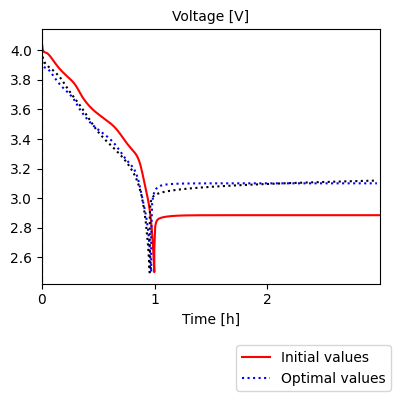

In [13]:
result.plot()